# Requirements & Imports

In [ ]:
!git clone https://github.com/hichamjanati/mutar
%cd mutar
!pip install -e .
%cd /content

%pip install pot

import site 
site.main()

fatal: destination path 'mutar' already exists and is not an empty directory.
/content/mutar
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mutar
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mutar
    Found existing installation: mutar 0.0.1
    Can't uninstall 'mutar'. No files were found to uninstall.
  Running setup.py develop for mutar
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import zipfile
import numpy as np
import pandas as pd
import ot
import matplotlib.cm as cm
import mutar
import random

from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mutar import GroupLasso, DirtyModel, MTW, IndLasso, MultiLevelLasso, ReMTW
from sklearn.utils import shuffle
from scipy.interpolate import make_interp_spline
from matplotlib.colors import get_named_colors_mapping

# MMASH Data Set

##Download MMASH

In [ ]:
!mkdir MMASH
!mkdir Data
!mkdir Data/figures
!wget -O MMASH/mmash.zip -r -N -c -np https://physionet.org/files/mmash/1.0.0/MMASH.zip

with zipfile.ZipFile('MMASH/mmash.zip', 'r') as zip_ref:
  zip_ref.extractall('MMASH')

!rm MMASH/mmash.zip

mkdir: cannot create directory ‘MMASH’: File exists
mkdir: cannot create directory ‘Data’: File exists
mkdir: cannot create directory ‘Data/figures’: File exists
will be placed in the single file you specified.

for details.

--2023-04-16 18:56:41--  https://physionet.org/files/mmash/1.0.0/MMASH.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24649620 (24M) [application/zip]
Saving to: ‘MMASH/mmash.zip’

MMASH/mmash.zip     100%[===================>]  23.51M  1019KB/s    in 23s     

2023-04-16 18:57:05 (1.04 MB/s) - ‘MMASH/mmash.zip’ saved [24649620/24649620]

FINISHED --2023-04-16 18:57:05--
Total wall clock time: 24s
Downloaded: 1 files, 24M in 23s (1.04 MB/s)


##Preprocess MMASH

In [ ]:
# Scripting constants
BASELINE_DATES = {1: "2020-08-01", 2: "2020-08-02"}
RANDOM_STATE = 12345
USER_FILE_PREFIX = "/content/MMASH/DataPaper/user_"

# Data set variables
RELEVANT_ACTIVITY = [4, 5]
USER_INFO_FIELDS = ["Age", "Height", "Weight"]
OMIT_TASKS = [4,]
OVERWRITES = {3: [5,60], 11: [4,6.5], 18: [0,22]}

# Pre-processing hyperparameters
IBIS_UPPER = 2.1
IBIS_LOWER = 0.3
FREQUENCY = "5min"
NOISE_UPPER = 55.0
NOISE_SAMPLE_PERCENT = 0.85
ZSCORE_UPPER = 2.5
HUMAN_FEQ = 2.0 * np.pi / 24

In [ ]:
def get_sleep_data(data):
    return data["Total Minutes in Bed"].sum() / 60

def get_activity_data(data):
    data = data.copy().dropna()
    del data["Unnamed: 0"]
    assign_pd_time_activity = lambda x: pd.to_timedelta(x["End"] + ":00") - pd.to_timedelta(x["Start"] + ":00")
    data["time_start_pd"] = data.apply(assign_pd_time_activity, axis=1)
    data["time_end_pd"] = data.apply(assign_pd_time_activity, axis=1)
    data["time_last_hour"] = data["time_end_pd"].apply(lambda x: x.seconds / 3600)
    data = data.loc[data["Activity"].isin(RELEVANT_ACTIVITY)]
    return data["time_last_hour"].sum() if not data.empty else 0

def get_user_info_data(data):
    data = data[USER_INFO_FIELDS].loc[0].values
    return np.array([data[0], data[1] / 100.0, data[2]])

def get_questionnaire_data(data):
    return data["Daily_stress"].loc[0]

def get_rr_data(data):
    data["time_pd"] = data.apply(lambda ds: pd.to_datetime(BASELINE_DATES.get(ds["day"], BASELINE_DATES[2]) + " " + str(ds["time"])), axis=1)
    data['ibi_s'] = [x if x < IBIS_UPPER and x > IBIS_LOWER else np.nan for x in data['ibi_s']]
    data = [w for _, w in data.dropna().groupby(pd.Grouper(key='time_pd', freq=FREQUENCY)) if not w.empty]
    rr_value = pd.DataFrame({
        "time_pd": [x["time_pd"].mean() for x in data],
        "value": [np.std(1000 * x["ibi_s"], ddof=1) for x in data]
    })
    no_noise = rr_value["value"] < NOISE_UPPER
    no_noise = rr_value[no_noise].sample(int(NOISE_SAMPLE_PERCENT * no_noise.sum()), random_state=RANDOM_STATE)
    rr_value = rr_value.drop(no_noise.index)
    rr_value = rr_value.loc[np.abs(stats.zscore(rr_value["value"])) < ZSCORE_UPPER]
    rr_value = rr_value.loc[rr_value["value"] > 12]
    rr_value["t_hour"] = rr_value["time_pd"].apply(lambda x: (x - pd.Timestamp(BASELINE_DATES[1] + " 00:00:00")).total_seconds() / 3600)
    return rr_value

In [ ]:
X_train_data, S_train_data, Y_train_data = [], [], []

for i in range(1, 23):
    if i in OMIT_TASKS:
        continue
    
    user_folder = USER_FILE_PREFIX + str(i)

    sleep_value = get_sleep_data(pd.read_csv(user_folder + "/sleep.csv"))
    activity_value = get_activity_data(pd.read_csv(user_folder + "/Activity.csv", header=0))
    user_info_value = get_user_info_data(pd.read_csv(user_folder + "/user_info.csv", header=0))
    questionnaire_value = get_questionnaire_data(pd.read_csv(user_folder + "/questionnaire.csv", header=0))
    rr_value = get_rr_data(pd.read_csv(user_folder + "/RR.csv", header=0))

    t_hour = rr_value["t_hour"].values
    s_vector = np.hstack([user_info_value, activity_value, sleep_value, questionnaire_value, 1])
    if i in OVERWRITES:
        s_vector[OVERWRITES[i][0]] = OVERWRITES[i][1]
    
    X_train_data.append(np.asarray([np.sin(HUMAN_FEQ * t_hour), np.cos(HUMAN_FEQ * t_hour), np.ones(t_hour.shape[0], )]).T)
    S_train_data.append(s_vector.reshape(-1, 1))
    Y_train_data.append(rr_value["value"].values.reshape((-1, 1)))

    print(i, ": ymean=", rr_value["value"].mean())

1 : ymean= 85.56476822678721
2 : ymean= 100.33561841324313
3 : ymean= 76.47079460368347
5 : ymean= 90.258288824083
6 : ymean= 88.1846116338921
7 : ymean= 85.14250546385614
8 : ymean= 96.14583988348869
9 : ymean= 88.87771062928078
10 : ymean= 96.38566520289122
11 : ymean= 87.05496543244831
12 : ymean= 71.64783622577323
13 : ymean= 75.48997318086856
14 : ymean= 72.4216758657783
15 : ymean= 89.94723825334468
16 : ymean= 90.6241899400592
17 : ymean= 84.65279849400704
18 : ymean= 97.55197871468567
19 : ymean= 93.08070948073929
20 : ymean= 81.19209160183755
21 : ymean= 77.00527424006555
22 : ymean= 83.18474159704846


# PhysioMTL Model Definition

In [ ]:
T_GRADIENT_THRESHOLD = 1e-8
W_GRADIENT_THRESHOLD = 1e-7

In [ ]:
class PhysioMTL:
    def __init__(self, cost_func, iterations=50, t_learn_rate=9e-2, t_iterations=200, w_learn_rate=1e-7, w_iterations=50, alpha=0.1, epsilon=1e-4, lambda_=5, sigma=10):
        self.cost_func = cost_func
        self.iterations = iterations
        self.t_learn_rate = t_learn_rate
        self.t_iterations = t_iterations
        self.w_learn_rate = w_learn_rate
        self.w_iterations = w_iterations
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.sigma = sigma

    def fit(self, X, S, Y):
        self.S = S
        X = np.array(X)
        Y = np.array(Y)
        W = self.solve_w_by_linear_regression(X, Y)
        C, K = self.get_cost_matrix(S)
        Pi = self.solve_ot_plan(C)
        self.T = self.converge_fw_gradient_descent(X, Y, W, K, Pi)

    def solve_w_by_linear_regression(self, X, Y):
        return np.concatenate([Y[i].T @ x @ np.linalg.inv(x.T @ x) for i, x in enumerate(X)]).T

    def get_cost_matrix(self, S):
        C = np.array([[self.cost_func(i, j) for j in S] for i in self.S])
        K = np.exp(-C / (2 * self.sigma**2))
        return C, K

    def solve_ot_plan(self, C):
        T = len(C)
        fracs = np.ones(T) / T
        transport_matrix = np.exp(-self.lambda_ * C)
        transport_matrix /= transport_matrix.sum()
        u = np.zeros(T)
        while np.max(np.abs(u - transport_matrix.sum(1))) > self.epsilon:
            u = transport_matrix.sum(1)
            transport_matrix *= fracs / u[:, None]
            transport_matrix *= fracs / transport_matrix.sum(0)[None, :]
        return transport_matrix

    def converge_fw_gradient_descent(self, X, Y, W, K, Pi):
        N = len(X)
        Z = np.zeros((W.shape[0], K.shape[0]))
        T = np.zeros((W.shape[0], K.shape[0]))
        for iteration in range(self.iterations):
            norm_last = 1e6
            for t in range(self.t_iterations):
                grad = [Pi[i, j] * (W[:, i:i+1] - T @ K[:, j:j+1]) @ K[:, j:j+1].T for i in range(N) for j in range(N)]
                grad = Z - self.alpha * 2 * sum(grad)
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < T_GRADIENT_THRESHOLD:
                    print(t, ": threshold met for T")
                    break
                norm_last = norm
                T = T - self.t_learn_rate * grad
            print(iteration, ": T gradient F-norm:", norm)

            norm_last = 1e6
            for w in range(self.w_iterations):
                grad = np.zeros_like(W)
                for t in range(N):
                    grad[:, t:t+1] = ((W[:, t:t+1].T @ X[t].T - Y[t].T) @ (X[t]) - self.alpha * sum([(T @ K[:, tt:tt+1] - W[:, tt:tt + 1]).T for tt in range(N)])).T
                norm = np.sum(np.square(grad))
                if np.abs(norm_last - norm) < W_GRADIENT_THRESHOLD:
                    print(w, ": threshold met for W")
                    break
                norm_last = norm
                W = W - self.w_learn_rate * grad
        return T

    def predict(self, X, S):
        if X is None and S is None:
            return [x @ self.W[:, i:i+1] for i, x in enumerate(self.X)]

        _, K = self.get_cost_matrix(S)
        K = [K[:, i:i+1] for i in range(len(S))]

        return [x @ self.T @ K[i] for i, x in enumerate(X)]

# Train the model

In [ ]:
model = PhysioMTL(lambda x_vec, y_vec: np.sqrt(np.mean(np.square(np.dot(np.array([1, 10., 1., 10, 1., 1., 0]), x_vec - y_vec)))))
model.fit(X_train_data, S_train_data, Y_train_data)

<ipython-input-8-2489dc13dabf>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-8-2489dc13dabf>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


0 : T gradient F-norm: 0.0345798390693929
1 : T gradient F-norm: 0.02276657579260545
2 : T gradient F-norm: 0.01571697892624365
3 : T gradient F-norm: 0.011480927463914395
4 : T gradient F-norm: 0.008907834342652084
5 : T gradient F-norm: 0.007318792771273572
6 : T gradient F-norm: 0.006313163112263196
7 : T gradient F-norm: 0.005654471169678731
8 : T gradient F-norm: 0.005203095184083875
9 : T gradient F-norm: 0.00487655520554798
10 : T gradient F-norm: 0.004626086127762517
11 : T gradient F-norm: 0.004422817058148071
12 : T gradient F-norm: 0.004249617825472786
13 : T gradient F-norm: 0.004096288747482535
14 : T gradient F-norm: 0.003956722717925311
15 : T gradient F-norm: 0.003827230844656388
16 : T gradient F-norm: 0.003705554516508479
17 : T gradient F-norm: 0.0035902824267179797
18 : T gradient F-norm: 0.003480506501858871
19 : T gradient F-norm: 0.0033756187764091223
20 : T gradient F-norm: 0.003275191422557883
21 : T gradient F-norm: 0.0031789058423203048
22 : T gradient F-norm

# Sample PhysioMTL Prediction

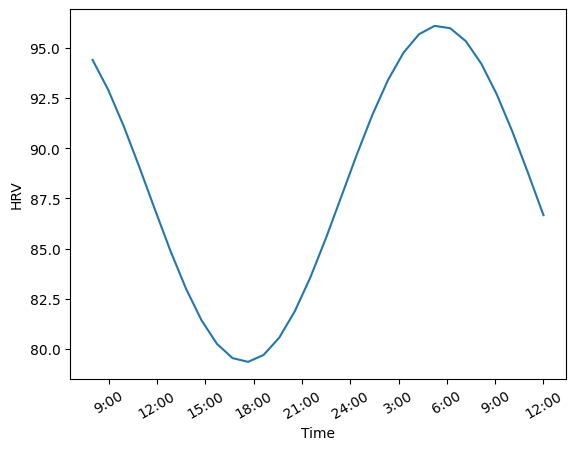

In [ ]:
S_ = np.array([[23.], [1.80], [85.], [1.], [7.], [20.], [1.]]).reshape(-1, 1)

T_ = np.linspace(8, 36, 30)
X_ = np.asarray([np.sin(HUMAN_FEQ * T_), np.cos(HUMAN_FEQ * T_), np.ones(30, )]).T

_, ax = plt.subplots()

ticks = [[9, '9:00'], [12, '12:00'], [15, '15:00'], [18, '18:00'], [21, '21:00'], [24, '24:00'], [27, '3:00'], [30, '6:00'], [33, '9:00'], [36, '12:00']]
ax.set_xticks([x[0] for x in ticks])
ax.set_xticklabels([x[1] for x in ticks], rotation=30)
ax.set_ylabel("HRV")
ax.set_xlabel("Time")

ax.plot(T_, model.predict([X_], [S_])[0])